In [44]:
import numpy as np
import matplotlib.pyplot as plt
from worldModels import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize
import scipy.io
import os.path
from utils import *
from run_simulations import *
from agents import *
import matplotlib.pyplot as plt
from sklearn import svm



%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [58]:
# For multiple simulations of the same param set
pswitchlst = [0.3]
prewlst = [0.95]

gammalst = [1.4]
epslst = [0.2]

betalst = 1 / np.linspace(0.05, 2, 12)

agent_type = 'qlearning' #'qlearning' or 'inf-based' or 'v-accumulation'

N_iters = 500
num_states = 2
obs_dim = 1
nblocks = 20 #100
eps = 0
hmm_fit = False
sigmoid_window = 30
ntrials_per_block = [10, 40]
seed = 0
rlow = 0
rhigh = 1
np.random.seed(123)

params = {'N_iters': N_iters, 'num_states': num_states, 'obs_dim': obs_dim, 
          'nblocks': nblocks, 'eps': eps, 'ntrials_per_block': ntrials_per_block,
          'gammalst': gammalst, 'epslst': epslst, 'seed': seed, 'type': agent_type, 'hmm_fit': hmm_fit,
         'pswitchlst': pswitchlst, 'prewlst': prewlst, 
          'betalst': betalst, 'seed': seed, 'sigmoid_window': sigmoid_window, 'rlow': rlow, 'rhigh': rhigh}

# Q-learning simulation
print('Starting q-learning simulation')
efflistQ, T11lstQ, T22lstQ, E1lstQ, E2lstQ, PRslopelistQ, PLslopelistQ, \
           PRoffsetlistQ, PLoffsetlistQ, LapseLQ, LapseRQ, ParamsAQ, ParamsBQ, ParamsCQ = run_repeated_single_agent(params)

# Inference-based simulation
print('Starting inf-based simulation')
params['type'] = 'inf-based'
efflistIB, T11lstIB, T22lstIB, E1lstIB, E2lstIB, PRslopelistIB, PLslopelistIB, \
           PRoffsetlistIB, PLoffsetlistIB, LapseLIB, LapseRIB, ParamsAIB, ParamsBIB, ParamsCIB = run_repeated_single_agent(params)

Starting q-learning simulation
Iteration =  0
Iteration =  1
Iteration =  2


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  3
Iteration =  4


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  5
Iteration =  6
Iteration =  7
Iteration =  8
Iteration =  9
Iteration =  10
Iteration =  11
Iteration =  12


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  13
Iteration =  14
Iteration =  15
Iteration =  16
Iteration =  17
Iteration =  18
Iteration =  19
Iteration =  20
Iteration =  21
Iteration =  22
Iteration =  23
Iteration =  24
Iteration =  25
Iteration =  26
Iteration =  27
Iteration =  28
Iteration =  29
Iteration =  30
Iteration =  31
Iteration =  32
Iteration =  33
Iteration =  34
Iteration =  35
Iteration =  36
Iteration =  37
Iteration =  38
Iteration =  39
Iteration =  40
Iteration =  41
Iteration =  42
Iteration =  43
Iteration =  44


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  45
Iteration =  46
Iteration =  47
Iteration =  48


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  49
Iteration =  50
Iteration =  51
Iteration =  52
Iteration =  53


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:123: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  54
Iteration =  55
Iteration =  56
Iteration =  57


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  58
Iteration =  59
Iteration =  60


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  61
Iteration =  62
Iteration =  63
Iteration =  64
Iteration =  65
Iteration =  66
Iteration =  67
Iteration =  68
Iteration =  69
Iteration =  70
Iteration =  71
Iteration =  72


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  73
Iteration =  74
Iteration =  75
Iteration =  76
Iteration =  77
Iteration =  78


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  79
Iteration =  80
Iteration =  81
Iteration =  82
Iteration =  83
Iteration =  84
Iteration =  85
Iteration =  86


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  87
Iteration =  88
Iteration =  89
Iteration =  90
Iteration =  91
Iteration =  92
Iteration =  93
Iteration =  94
Iteration =  95
Iteration =  96
Iteration =  97


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  98
Iteration =  99
Iteration =  100
Iteration =  101
Iteration =  102
Iteration =  103
Iteration =  104
Iteration =  105
Iteration =  106
Iteration =  107


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:122: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[1::2, :], axis=0)
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:123: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  108
Iteration =  109
Iteration =  110
Iteration =  111
Iteration =  112
Iteration =  113


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  114
Iteration =  115
Iteration =  116


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  117
Iteration =  118
Iteration =  119
Iteration =  120
Iteration =  121
Iteration =  122
Iteration =  123
Iteration =  124
Iteration =  125


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  126
Iteration =  127
Iteration =  128


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  129
Iteration =  130
Iteration =  131


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  132
Iteration =  133
Iteration =  134
Iteration =  135
Iteration =  136
Iteration =  137
Iteration =  138
Iteration =  139
Iteration =  140


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  141
Iteration =  142
Iteration =  143


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:122: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  144
Iteration =  145
Iteration =  146


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  147
Iteration =  148
Iteration =  149
Iteration =  150
Iteration =  151
Iteration =  152
Iteration =  153
Iteration =  154
Iteration =  155


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  156
Iteration =  157
Iteration =  158
Iteration =  159
Iteration =  160
Iteration =  161
Iteration =  162
Iteration =  163


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  164
Iteration =  165
Iteration =  166
Iteration =  167
Iteration =  168
Iteration =  169
Iteration =  170
Iteration =  171
Iteration =  172
Iteration =  173
Iteration =  174
Iteration =  175
Iteration =  176
Iteration =  177
Iteration =  178
Iteration =  179
Iteration =  180
Iteration =  181
Iteration =  182
Iteration =  183
Iteration =  184
Iteration =  185
Iteration =  186
Iteration =  187


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  188
Iteration =  189
Iteration =  190
Iteration =  191
Iteration =  192
Iteration =  193
Iteration =  194
Iteration =  195
Iteration =  196
Iteration =  197
Iteration =  198
Iteration =  199
Iteration =  200
Iteration =  201
Iteration =  202
Iteration =  203
Iteration =  204
Iteration =  205


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:122: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  206
Iteration =  207
Iteration =  208


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  209
Iteration =  210
Iteration =  211
Iteration =  212
Iteration =  213
Iteration =  214


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  215
Iteration =  216
Iteration =  217


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  218
Iteration =  219
Iteration =  220


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  221
Iteration =  222
Iteration =  223
Iteration =  224
Iteration =  225
Iteration =  226
Iteration =  227
Iteration =  228
Iteration =  229
Iteration =  230
Iteration =  231
Iteration =  232
Iteration =  233
Iteration =  234
Iteration =  235


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  236
Iteration =  237
Iteration =  238


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:126: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  239
Iteration =  240
Iteration =  241


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  242
Iteration =  243
Iteration =  244
Iteration =  245
Iteration =  246
Iteration =  247


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  248
Iteration =  249
Iteration =  250


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  251
Iteration =  252
Iteration =  253
Iteration =  254
Iteration =  255
Iteration =  256
Iteration =  257
Iteration =  258
Iteration =  259
Iteration =  260
Iteration =  261


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:126: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  262
Iteration =  263


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  264
Iteration =  265
Iteration =  266
Iteration =  267
Iteration =  268
Iteration =  269
Iteration =  270
Iteration =  271
Iteration =  272
Iteration =  273
Iteration =  274
Iteration =  275
Iteration =  276
Iteration =  277
Iteration =  278
Iteration =  279
Iteration =  280
Iteration =  281
Iteration =  282
Iteration =  283
Iteration =  284
Iteration =  285
Iteration =  286
Iteration =  287
Iteration =  288
Iteration =  289
Iteration =  290
Iteration =  291


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  292
Iteration =  293
Iteration =  294
Iteration =  295
Iteration =  296
Iteration =  297


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  298
Iteration =  299
Iteration =  300
Iteration =  301
Iteration =  302
Iteration =  303


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  304
Iteration =  305
Iteration =  306
Iteration =  307
Iteration =  308
Iteration =  309


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  310
Iteration =  311
Iteration =  312
Iteration =  313
Iteration =  314
Iteration =  315
Iteration =  316
Iteration =  317
Iteration =  318
Iteration =  319
Iteration =  320
Iteration =  321
Iteration =  322
Iteration =  323
Iteration =  324


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:122: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  325
Iteration =  326
Iteration =  327
Iteration =  328
Iteration =  329
Iteration =  330


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  331
Iteration =  332
Iteration =  333


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  334
Iteration =  335
Iteration =  336
Iteration =  337
Iteration =  338
Iteration =  339


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  340
Iteration =  341
Iteration =  342
Iteration =  343
Iteration =  344
Iteration =  345


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  346
Iteration =  347
Iteration =  348
Iteration =  349


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  350
Iteration =  351


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:126: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  352
Iteration =  353
Iteration =  354
Iteration =  355
Iteration =  356
Iteration =  357
Iteration =  358
Iteration =  359
Iteration =  360
Iteration =  361
Iteration =  362
Iteration =  363


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  364
Iteration =  365
Iteration =  366
Iteration =  367
Iteration =  368
Iteration =  369
Iteration =  370


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  371
Iteration =  372


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  373
Iteration =  374
Iteration =  375
Iteration =  376
Iteration =  377


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:126: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  378
Iteration =  379
Iteration =  380
Iteration =  381
Iteration =  382


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  383
Iteration =  384


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  385
Iteration =  386
Iteration =  387
Iteration =  388
Iteration =  389
Iteration =  390
Iteration =  391
Iteration =  392
Iteration =  393
Iteration =  394
Iteration =  395
Iteration =  396


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  397
Iteration =  398


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:122: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  399
Iteration =  400
Iteration =  401
Iteration =  402
Iteration =  403
Iteration =  404
Iteration =  405
Iteration =  406
Iteration =  407
Iteration =  408
Iteration =  409


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  410
Iteration =  411
Iteration =  412
Iteration =  413
Iteration =  414
Iteration =  415


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  416
Iteration =  417
Iteration =  418
Iteration =  419
Iteration =  420
Iteration =  421
Iteration =  422
Iteration =  423
Iteration =  424


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  425
Iteration =  426
Iteration =  427
Iteration =  428
Iteration =  429
Iteration =  430
Iteration =  431
Iteration =  432
Iteration =  433
Iteration =  434
Iteration =  435
Iteration =  436
Iteration =  437
Iteration =  438
Iteration =  439
Iteration =  440
Iteration =  441


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  442
Iteration =  443
Iteration =  444


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  445
Iteration =  446
Iteration =  447


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  448
Iteration =  449
Iteration =  450
Iteration =  451
Iteration =  452
Iteration =  453
Iteration =  454
Iteration =  455
Iteration =  456


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  457
Iteration =  458
Iteration =  459
Iteration =  460
Iteration =  461


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  462
Iteration =  463
Iteration =  464
Iteration =  465
Iteration =  466
Iteration =  467
Iteration =  468
Iteration =  469
Iteration =  470


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  471
Iteration =  472
Iteration =  473
Iteration =  474
Iteration =  475
Iteration =  476


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Iteration =  477
Iteration =  478
Iteration =  479
Iteration =  480
Iteration =  481
Iteration =  482
Iteration =  483
Iteration =  484
Iteration =  485
Iteration =  486
Iteration =  487
Iteration =  488
Iteration =  489
Iteration =  490
Iteration =  491
Iteration =  492
Iteration =  493
Iteration =  494
Iteration =  495
Iteration =  496
Iteration =  497
Iteration =  498
Iteration =  499


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:43: RuntimeWarning: overflow encountered in exp
  return p[2] + (1 - 2 * p[2]) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


Starting inf-based simulation
Iteration =  0
Iteration =  1
Iteration =  2
Iteration =  3
Iteration =  4
Iteration =  5
Iteration =  6
Iteration =  7
Iteration =  8
Iteration =  9
Iteration =  10
Iteration =  11
Iteration =  12
Iteration =  13
Iteration =  14
Iteration =  15
Iteration =  16
Iteration =  17
Iteration =  18
Iteration =  19
Iteration =  20
Iteration =  21
Iteration =  22
Iteration =  23
Iteration =  24
Iteration =  25
Iteration =  26
Iteration =  27
Iteration =  28
Iteration =  29
Iteration =  30
Iteration =  31
Iteration =  32
Iteration =  33
Iteration =  34
Iteration =  35
Iteration =  36
Iteration =  37
Iteration =  38
Iteration =  39
Iteration =  40
Iteration =  41
Iteration =  42
Iteration =  43
Iteration =  44


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  45
Iteration =  46
Iteration =  47
Iteration =  48
Iteration =  49
Iteration =  50
Iteration =  51
Iteration =  52
Iteration =  53
Iteration =  54
Iteration =  55
Iteration =  56
Iteration =  57
Iteration =  58
Iteration =  59
Iteration =  60
Iteration =  61
Iteration =  62
Iteration =  63
Iteration =  64
Iteration =  65
Iteration =  66
Iteration =  67
Iteration =  68
Iteration =  69
Iteration =  70
Iteration =  71
Iteration =  72
Iteration =  73
Iteration =  74
Iteration =  75
Iteration =  76
Iteration =  77
Iteration =  78
Iteration =  79
Iteration =  80
Iteration =  81
Iteration =  82
Iteration =  83
Iteration =  84
Iteration =  85
Iteration =  86
Iteration =  87
Iteration =  88
Iteration =  89
Iteration =  90
Iteration =  91
Iteration =  92
Iteration =  93
Iteration =  94
Iteration =  95


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:122: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  96
Iteration =  97
Iteration =  98


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  99
Iteration =  100
Iteration =  101
Iteration =  102
Iteration =  103
Iteration =  104
Iteration =  105
Iteration =  106
Iteration =  107
Iteration =  108
Iteration =  109
Iteration =  110
Iteration =  111
Iteration =  112
Iteration =  113
Iteration =  114
Iteration =  115
Iteration =  116
Iteration =  117
Iteration =  118
Iteration =  119
Iteration =  120
Iteration =  121
Iteration =  122
Iteration =  123
Iteration =  124
Iteration =  125
Iteration =  126
Iteration =  127
Iteration =  128
Iteration =  129
Iteration =  130
Iteration =  131
Iteration =  132
Iteration =  133
Iteration =  134
Iteration =  135
Iteration =  136
Iteration =  137
Iteration =  138
Iteration =  139
Iteration =  140
Iteration =  141
Iteration =  142
Iteration =  143


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:126: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  144
Iteration =  145
Iteration =  146
Iteration =  147
Iteration =  148
Iteration =  149
Iteration =  150
Iteration =  151
Iteration =  152
Iteration =  153
Iteration =  154
Iteration =  155
Iteration =  156
Iteration =  157
Iteration =  158
Iteration =  159
Iteration =  160
Iteration =  161
Iteration =  162
Iteration =  163
Iteration =  164
Iteration =  165
Iteration =  166
Iteration =  167
Iteration =  168
Iteration =  169
Iteration =  170


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  171
Iteration =  172
Iteration =  173
Iteration =  174
Iteration =  175
Iteration =  176
Iteration =  177
Iteration =  178
Iteration =  179
Iteration =  180
Iteration =  181
Iteration =  182
Iteration =  183
Iteration =  184
Iteration =  185
Iteration =  186
Iteration =  187
Iteration =  188
Iteration =  189
Iteration =  190
Iteration =  191
Iteration =  192
Iteration =  193
Iteration =  194
Iteration =  195
Iteration =  196
Iteration =  197
Iteration =  198
Iteration =  199
Iteration =  200
Iteration =  201
Iteration =  202
Iteration =  203
Iteration =  204
Iteration =  205
Iteration =  206
Iteration =  207
Iteration =  208
Iteration =  209
Iteration =  210
Iteration =  211
Iteration =  212
Iteration =  213
Iteration =  214


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:123: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[::2, :], axis=0)
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  215
Iteration =  216
Iteration =  217
Iteration =  218
Iteration =  219
Iteration =  220
Iteration =  221
Iteration =  222
Iteration =  223
Iteration =  224
Iteration =  225
Iteration =  226
Iteration =  227
Iteration =  228
Iteration =  229
Iteration =  230
Iteration =  231
Iteration =  232
Iteration =  233
Iteration =  234
Iteration =  235
Iteration =  236
Iteration =  237
Iteration =  238
Iteration =  239
Iteration =  240
Iteration =  241
Iteration =  242
Iteration =  243
Iteration =  244
Iteration =  245
Iteration =  246
Iteration =  247
Iteration =  248
Iteration =  249
Iteration =  250
Iteration =  251
Iteration =  252
Iteration =  253


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  254
Iteration =  255
Iteration =  256
Iteration =  257
Iteration =  258
Iteration =  259
Iteration =  260
Iteration =  261
Iteration =  262
Iteration =  263
Iteration =  264
Iteration =  265
Iteration =  266
Iteration =  267
Iteration =  268
Iteration =  269
Iteration =  270
Iteration =  271
Iteration =  272
Iteration =  273
Iteration =  274
Iteration =  275
Iteration =  276
Iteration =  277
Iteration =  278
Iteration =  279
Iteration =  280


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:123: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  281
Iteration =  282
Iteration =  283
Iteration =  284
Iteration =  285
Iteration =  286
Iteration =  287
Iteration =  288
Iteration =  289
Iteration =  290
Iteration =  291
Iteration =  292
Iteration =  293
Iteration =  294
Iteration =  295
Iteration =  296
Iteration =  297
Iteration =  298
Iteration =  299
Iteration =  300
Iteration =  301


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:122: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  302
Iteration =  303
Iteration =  304
Iteration =  305
Iteration =  306
Iteration =  307


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:126: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  308
Iteration =  309
Iteration =  310
Iteration =  311
Iteration =  312
Iteration =  313
Iteration =  314
Iteration =  315
Iteration =  316
Iteration =  317
Iteration =  318
Iteration =  319
Iteration =  320
Iteration =  321
Iteration =  322
Iteration =  323
Iteration =  324
Iteration =  325
Iteration =  326
Iteration =  327
Iteration =  328
Iteration =  329
Iteration =  330
Iteration =  331
Iteration =  332
Iteration =  333
Iteration =  334
Iteration =  335
Iteration =  336
Iteration =  337
Iteration =  338
Iteration =  339
Iteration =  340
Iteration =  341
Iteration =  342


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:122: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[1::2, :], axis=0)


Iteration =  343
Iteration =  344
Iteration =  345
Iteration =  346
Iteration =  347
Iteration =  348
Iteration =  349
Iteration =  350
Iteration =  351


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  352
Iteration =  353
Iteration =  354
Iteration =  355
Iteration =  356
Iteration =  357
Iteration =  358
Iteration =  359
Iteration =  360


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:123: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  361
Iteration =  362
Iteration =  363
Iteration =  364
Iteration =  365
Iteration =  366
Iteration =  367
Iteration =  368
Iteration =  369
Iteration =  370
Iteration =  371
Iteration =  372
Iteration =  373
Iteration =  374
Iteration =  375
Iteration =  376
Iteration =  377
Iteration =  378
Iteration =  379
Iteration =  380
Iteration =  381
Iteration =  382
Iteration =  383
Iteration =  384
Iteration =  385
Iteration =  386
Iteration =  387
Iteration =  388
Iteration =  389
Iteration =  390
Iteration =  391
Iteration =  392
Iteration =  393
Iteration =  394
Iteration =  395
Iteration =  396
Iteration =  397
Iteration =  398
Iteration =  399
Iteration =  400
Iteration =  401
Iteration =  402
Iteration =  403
Iteration =  404
Iteration =  405


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:123: RuntimeWarning: Mean of empty slice
  rightAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  406
Iteration =  407
Iteration =  408
Iteration =  409
Iteration =  410
Iteration =  411
Iteration =  412
Iteration =  413
Iteration =  414
Iteration =  415
Iteration =  416
Iteration =  417
Iteration =  418
Iteration =  419
Iteration =  420
Iteration =  421
Iteration =  422
Iteration =  423
Iteration =  424
Iteration =  425
Iteration =  426
Iteration =  427
Iteration =  428
Iteration =  429
Iteration =  430
Iteration =  431
Iteration =  432
Iteration =  433
Iteration =  434
Iteration =  435
Iteration =  436
Iteration =  437
Iteration =  438
Iteration =  439
Iteration =  440
Iteration =  441
Iteration =  442
Iteration =  443
Iteration =  444
Iteration =  445
Iteration =  446
Iteration =  447
Iteration =  448
Iteration =  449
Iteration =  450
Iteration =  451
Iteration =  452
Iteration =  453
Iteration =  454
Iteration =  455
Iteration =  456
Iteration =  457
Iteration =  458
Iteration =  459
Iteration =  460
Iteration =  461
Iteration =  462
Iteration =  463
Iteration =  4

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:127: RuntimeWarning: Mean of empty slice
  leftAverage = np.nanmean(choicelst[::2, :], axis=0)


Iteration =  481
Iteration =  482
Iteration =  483
Iteration =  484
Iteration =  485
Iteration =  486
Iteration =  487
Iteration =  488
Iteration =  489
Iteration =  490
Iteration =  491
Iteration =  492
Iteration =  493
Iteration =  494
Iteration =  495
Iteration =  496
Iteration =  497
Iteration =  498
Iteration =  499


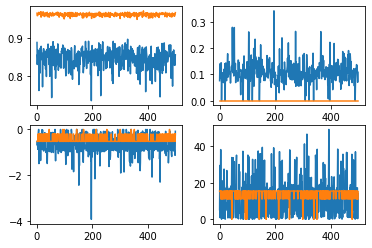

In [59]:
# efflist, T11lst, T22lst, E1lst, E2lst, PRslopelist, PLslopelist, \
#            PRoffsetlist, PLoffsetlist, LapseL, LapseR, ParamsA, ParamsB, ParamsC
plt.subplot(221)
plt.plot(efflistQ)
plt.plot(efflistIB)

plt.subplot(222)
plt.plot(LapseLQ)
plt.plot(LapseLIB)

plt.subplot(223)
plt.plot(PLoffsetlistQ)
plt.plot(PLoffsetlistIB)

plt.subplot(224)
plt.plot(PLslopelistQ)
plt.plot(PLslopelistIB)

In [75]:
# Make the training and test sets
XQ = np.vstack([efflistQ, LapseLQ, PLoffsetlistQ, PLslopelistQ])
XIB = np.vstack([efflistIB, LapseLIB, PLoffsetlistIB, PLslopelistIB])
Xall = np.hstack([XQ, XIB])
yall = np.array([0] * XQ.shape[1] + [1] * XIB.shape[1])

#Normalize
mean = np.mean(Xall, axis=1)
std = np.std(Xall, axis=1)
Xall = (Xall.T - mean) / std

# Shuffle
order = np.arange(Xall.shape[0])
np.random.shuffle(order)
Xall = Xall[order,:]

Xtrain = Xall[:75,:]
Xtest = Xall[75:,:]
ytrain = yall[order][:75]
ytest = yall[order][75:]

clf = svm.SVC()
clf.fit(Xtrain, ytrain)


SVC()

In [77]:
preds = clf.predict(Xtest)
perf = sum((preds - ytest)**2 == 0) / len(preds)
print(perf)

1.0


In [14]:
Xall.shape

(4, 100)

In [22]:
np.random.shuffle(Xall.T)

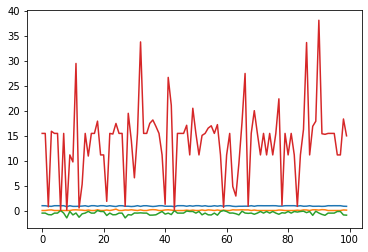

In [30]:
plt.plot(Xall.T);